# 1 . Euler approximation of UHMR system

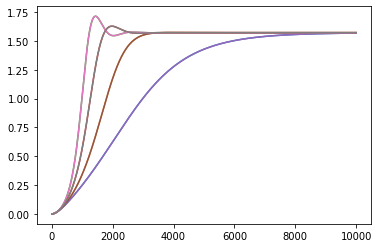

In [1]:
%clear
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense
from sklearn.metrics import mean_squared_error


from Euler_approximation import euler #import euler approximation

[a1,a2,a3,a4]=[20,40,60,80] 
[phi1_a1,phi2_a1]=euler(a1)
[phi1_a2,phi2_a2]=euler(a2)
[phi1_a3,phi2_a3]=euler(a3)
[phi1_a4,phi2_a4]=euler(a4)


plt.plot(phi1_a1)
plt.plot(phi1_a2)
plt.plot(phi1_a4)
plt.plot(phi1_a3)

# 2. Data pre-processing.




## 2. 1 Pre-process the training datasets
Using four sets of magnetic field strength 20Oe, 40Oe,60Oe, 80Oe.    a=[20,40,60,80].


In [4]:
[a1,a2,a3,a4]=[20,40,60,80] # four sets of magnetic field strength 
 # Get data sequence through Euler approximatiion
[phi1_a1,phi2_a1]=euler(a1)
[phi1_a2,phi2_a2]=euler(a2)
[phi1_a3,phi2_a3]=euler(a3)
[phi1_a4,phi2_a4]=euler(a4)

split_time =8000
T=10000
di=0.001
#Put all angle sequence together
phi1_all=np.concatenate((phi1_a1[:split_time],phi1_a2[:split_time],phi1_a3[:split_time],phi1_a4[:split_time]),axis=0)

 # Calculate the angular velocity
phi2_a1[:split_time]=(phi1_a1[1:split_time+1]-phi1_a1[:split_time])/di
phi2_a2[:split_time]=(phi1_a2[1:split_time+1]-phi1_a2[:split_time])/di
phi2_a3[:split_time]=(phi1_a3[1:split_time+1]-phi1_a3[:split_time])/di
phi2_a4[:split_time]=(phi1_a4[1:split_time+1]-phi1_a4[:split_time])/di
phi2_all=np.concatenate((phi2_a1[:split_time],phi2_a2[:split_time],phi2_a3[:split_time],phi2_a4[:split_time]),axis=0)

 # Calculate the angular acceleration
phi2_diff_all=np.concatenate((phi2_a1[1:split_time+1]-phi2_a1[:split_time],phi2_a2[1:split_time+1]-phi2_a2[:split_time],
                              phi2_a3[1:split_time+1]-phi2_a3[:split_time],phi2_a4[1:split_time+1]-phi2_a4[:split_time]),axis=0)
phi2_diff_all=phi2_diff_all/di

# Get the control input sequence 
input_a1=a1*np.ones(T)
input_a2=a2*np.ones(T)
input_a3=a3*np.ones(T)
input_a4=a4*np.ones(T)
input=np.concatenate((input_a1[:split_time],input_a2[:split_time],input_a3[:split_time],input_a4[:split_time]),axis=0)
 
# Stack all data together
series_input=np.stack((phi1_all,phi2_all,input,phi2_diff_all),axis=1)
series_input=series_input.reshape(4*split_time,4)

#Shuffle data for avioding overfitting
series_input=tf.random.shuffle(series_input)

x_train=series_input[:,0:3] # Training input dataset
y_train=series_input[:,3] # Training output dataset


## 2. 2 Pre-process the validation dataset
Using the magnetic field strength 50Oe. a=50.

In [3]:
a=50 # 
[phi1_valid,phi2_valid]=euler(a)

split_time =5000

 # Calculate the angular acceleration
phi2_diff_valid=(phi2_valid[1:split_time+1]-phi2_valid[:split_time])/di

# Get the control input sequence 
input_valid=a*np.ones(T)

# Stack all data together
series_input=np.stack((phi1_valid[:split_time],phi2_valid[:split_time],input_valid[:split_time],phi2_diff_valid),axis=1)
series_input=series_input.reshape(split_time,4)

#Shuffle data for avioding overfitting
series_input=tf.random.shuffle(series_input)
 
x_valid=series_input[:,0:3] # Validation input dataset
y_valid=series_input[:,3]  # Validation output dataset


# 3. Train FFNN

In [4]:
MAE_all = np.ones((1, 10)).squeeze()
for seed in range(10):  #Try different seed and the get the best one.     
        tf.random.set_seed(5+seed*5)
        print("seed=%d"%(5+seed*5))
        model = tf.keras.Sequential([tf.keras.layers.Dense(60,kernel_initializer='glorot_uniform',activation="elu"),
                                     tf.keras.layers.Dense(30,kernel_initializer='glorot_uniform', activation="elu"),
                                     tf.keras.layers.Dense(1)])

        optimizer = tf.keras.optimizers.SGD(lr=5e-4, momentum=0.9)

        model.compile(loss=tf.keras.losses.Huber(),
                      optimizer=optimizer,
                      metrics=["mae"])

        class CustomCallbacks(tf.keras.callbacks.Callback):
            def on_epoch_end(self, epoch, logs={}):
              if(logs.get('mae')<0.1):
                print("\n 99% acc reached")
                self.model.stop_training = True

        history= model.fit(x_train, y_train, epochs=800, callbacks=[CustomCallbacks()],verbose=1)
        trainPredict = model.predict(x_train)
        error=np.abs(trainPredict[:,0]*0.001-y_train*0.001)
        MAE_all[seed]=np.mean(error)  # the mean absolute error
       
        if MAE_all[seed]==np.min(MAE_all):
            model.save('Models/FFNN.h5')
            m=seed

seed=5
Epoch 1/800
1000/1000 [==============================] - 1s 303us/step - loss: 0.4902 - mae: 0.7228
Epoch 2/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.2515 - mae: 0.4390
Epoch 3/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.2490 - mae: 0.4374
Epoch 4/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.2395 - mae: 0.4207
Epoch 5/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.2354 - mae: 0.4176
Epoch 6/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.2212 - mae: 0.3987
Epoch 7/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.2298 - mae: 0.4083
Epoch 8/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.2146 - mae: 0.3824
Epoch 9/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.2155 - mae: 0.3820
Epoch 10/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.2252 - mae:

1000/1000 [==============================] - 0s 291us/step - loss: 0.0933 - mae: 0.2523
Epoch 163/800
1000/1000 [==============================] - 0s 291us/step - loss: 0.0886 - mae: 0.2429
Epoch 164/800
1000/1000 [==============================] - 0s 291us/step - loss: 0.0921 - mae: 0.2484
Epoch 165/800
1000/1000 [==============================] - 0s 289us/step - loss: 0.0833 - mae: 0.2305
Epoch 166/800
1000/1000 [==============================] - 0s 291us/step - loss: 0.0762 - mae: 0.2142
Epoch 167/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0865 - mae: 0.2437
Epoch 168/800
1000/1000 [==============================] - 0s 291us/step - loss: 0.0836 - mae: 0.2342
Epoch 169/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0832 - mae: 0.2335
Epoch 170/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0832 - mae: 0.2332
Epoch 171/800
1000/1000 [==============================] - 0s 291us/step - loss: 0.0910 - mae: 0

1000/1000 [==============================] - 0s 295us/step - loss: 0.0532 - mae: 0.1498
Epoch 323/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0444 - mae: 0.1332
Epoch 324/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0426 - mae: 0.1292
Epoch 325/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0517 - mae: 0.1476
Epoch 326/800
1000/1000 [==============================] - 0s 301us/step - loss: 0.0411 - mae: 0.1309
Epoch 327/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0466 - mae: 0.1400
Epoch 328/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0423 - mae: 0.1289
Epoch 329/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0398 - mae: 0.1227
Epoch 330/800
1000/1000 [==============================] - 0s 304us/step - loss: 0.0474 - mae: 0.1421
Epoch 331/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0473 - mae: 0

1000/1000 [==============================] - 0s 292us/step - loss: 0.0429 - mae: 0.1337
Epoch 483/800
1000/1000 [==============================] - 0s 287us/step - loss: 0.0498 - mae: 0.1447
Epoch 484/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0348 - mae: 0.1163
Epoch 485/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0383 - mae: 0.1228
Epoch 486/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0377 - mae: 0.1187
Epoch 487/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0443 - mae: 0.1329
Epoch 488/800
1000/1000 [==============================] - 0s 292us/step - loss: 0.0451 - mae: 0.1331
Epoch 489/800
1000/1000 [==============================] - 0s 292us/step - loss: 0.0394 - mae: 0.1258
Epoch 490/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0399 - mae: 0.1237
Epoch 491/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0375 - mae: 0

1000/1000 [==============================] - 0s 293us/step - loss: 0.0330 - mae: 0.1147
Epoch 643/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0347 - mae: 0.1169
Epoch 644/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0337 - mae: 0.1169
Epoch 645/800
1000/1000 [==============================] - 0s 291us/step - loss: 0.0340 - mae: 0.1158
Epoch 646/800
1000/1000 [==============================] - 0s 292us/step - loss: 0.0376 - mae: 0.1243
Epoch 647/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0320 - mae: 0.1125
Epoch 648/800
1000/1000 [==============================] - 0s 292us/step - loss: 0.0332 - mae: 0.1155
Epoch 649/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0355 - mae: 0.1174
Epoch 650/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0400 - mae: 0.1299
Epoch 651/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0387 - mae: 0

KeyboardInterrupt: 

Form above cell, the best seed is 45. Thus, we train the FFNN by using seed(45).  

In [5]:
tf.random.set_seed(45)
model = tf.keras.Sequential([tf.keras.layers.Dense(60,kernel_initializer='glorot_uniform',activation="elu"),
                             tf.keras.layers.Dense(30,kernel_initializer='glorot_uniform', activation="elu"),
                             tf.keras.layers.Dense(1)])

optimizer = tf.keras.optimizers.SGD(lr=5e-4, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

class CustomCallbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      if(logs.get('mae')<0.1):
        print("\n 99% acc reached")
        self.model.stop_training = True

history= model.fit(x_train, y_train, epochs=800, callbacks=[CustomCallbacks()], verbose=1)
model.save('Models/FFNN.h5')


Epoch 1/800
1000/1000 [==============================] - 0s 302us/step - loss: 0.3043 - mae: 0.5342
Epoch 2/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.2470 - mae: 0.4390
Epoch 3/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.2556 - mae: 0.4508
Epoch 4/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.2291 - mae: 0.4221
Epoch 5/800
1000/1000 [==============================] - 0s 304us/step - loss: 0.2380 - mae: 0.4177
Epoch 6/800
1000/1000 [==============================] - 0s 306us/step - loss: 0.2185 - mae: 0.3971
Epoch 7/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.2200 - mae: 0.3912
Epoch 8/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.2171 - mae: 0.3804
Epoch 9/800
1000/1000 [==============================] - 0s 301us/step - loss: 0.2220 - mae: 0.3902
Epoch 10/800
1000/1000 [==============================] - 0s 305us/step - loss: 0.2096 - mae: 0.3782

1000/1000 [==============================] - 0s 299us/step - loss: 0.0659 - mae: 0.1817
Epoch 163/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.1407 - mae: 0.2911
Epoch 164/800
1000/1000 [==============================] - 0s 307us/step - loss: 0.0679 - mae: 0.1895
Epoch 165/800
1000/1000 [==============================] - 0s 289us/step - loss: 0.0677 - mae: 0.1850
Epoch 166/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0828 - mae: 0.2116
Epoch 167/800
1000/1000 [==============================] - 0s 305us/step - loss: 0.0694 - mae: 0.1865
Epoch 168/800
1000/1000 [==============================] - 0s 301us/step - loss: 0.0820 - mae: 0.2036
Epoch 169/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0737 - mae: 0.1928
Epoch 170/800
1000/1000 [==============================] - 0s 298us/step - loss: 0.0801 - mae: 0.2103
Epoch 171/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.1735 - mae: 0

1000/1000 [==============================] - 0s 286us/step - loss: 0.0490 - mae: 0.1395
Epoch 323/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0497 - mae: 0.1432
Epoch 324/800
1000/1000 [==============================] - 0s 296us/step - loss: 0.0423 - mae: 0.1255
Epoch 325/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0488 - mae: 0.1386
Epoch 326/800
1000/1000 [==============================] - 0s 308us/step - loss: 0.0470 - mae: 0.1335
Epoch 327/800
1000/1000 [==============================] - 0s 301us/step - loss: 0.0471 - mae: 0.1356
Epoch 328/800
1000/1000 [==============================] - 0s 309us/step - loss: 0.0471 - mae: 0.1357
Epoch 329/800
1000/1000 [==============================] - 0s 305us/step - loss: 0.0465 - mae: 0.1372
Epoch 330/800
1000/1000 [==============================] - 0s 325us/step - loss: 0.0490 - mae: 0.1384
Epoch 331/800
1000/1000 [==============================] - 0s 312us/step - loss: 0.0463 - mae: 0

1000/1000 [==============================] - 0s 296us/step - loss: 0.0396 - mae: 0.1176
Epoch 483/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0490 - mae: 0.1365
Epoch 484/800
1000/1000 [==============================] - 0s 290us/step - loss: 0.0366 - mae: 0.1138
Epoch 485/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0370 - mae: 0.1111
Epoch 486/800
1000/1000 [==============================] - 0s 294us/step - loss: 0.0409 - mae: 0.1214
Epoch 487/800
1000/1000 [==============================] - 0s 299us/step - loss: 0.0384 - mae: 0.1181
Epoch 488/800
1000/1000 [==============================] - 0s 297us/step - loss: 0.0445 - mae: 0.1282
Epoch 489/800
1000/1000 [==============================] - 0s 295us/step - loss: 0.0351 - mae: 0.1098
Epoch 490/800
1000/1000 [==============================] - 0s 302us/step - loss: 0.0425 - mae: 0.1250
Epoch 491/800
1000/1000 [==============================] - 0s 309us/step - loss: 0.0389 - mae: 0

1000/1000 [==============================] - 0s 290us/step - loss: 0.0335 - mae: 0.1072
Epoch 643/800
1000/1000 [==============================] - 0s 290us/step - loss: 0.0382 - mae: 0.1171
Epoch 644/800
1000/1000 [==============================] - 0s 291us/step - loss: 0.0339 - mae: 0.1124
Epoch 645/800
1000/1000 [==============================] - 0s 289us/step - loss: 0.0344 - mae: 0.1131
Epoch 646/800
1000/1000 [==============================] - 0s 292us/step - loss: 0.0344 - mae: 0.1127
Epoch 647/800
1000/1000 [==============================] - 0s 293us/step - loss: 0.0359 - mae: 0.1140
Epoch 648/800
1000/1000 [==============================] - 0s 303us/step - loss: 0.0350 - mae: 0.1137
Epoch 649/800
1000/1000 [==============================] - 0s 306us/step - loss: 0.0367 - mae: 0.1157
Epoch 650/800
1000/1000 [==============================] - 0s 300us/step - loss: 0.0377 - mae: 0.1178
Epoch 651/800
1000/1000 [==============================] - 0s 302us/step - loss: 0.0357 - mae: 0

# 4 Check the prediction result ( Angular acceleration)

0.0001035165794865525
0.4067125803393959


0.0002545202299869096

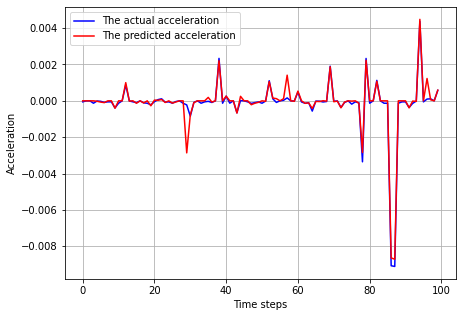

In [6]:
# Check the prediction result with training dataset

model = tf.keras.models.load_model("Models/FFNN.h5") # Load the trained FFNN
trainPredict = model.predict(x_train)

#plot prediction result
plt.figure(figsize=(7,5))
plt.plot(trainPredict[3900:4000,0]*0.001, "b",label="The actual acceleration")
plt.plot(y_train[3900:4000]*0.001, "r", label="The predicted acceleration")
plt.legend()
plt.grid(True)
plt.xlabel("Time steps")
plt.ylabel("Acceleration")

# Calculate the MAE
error=np.abs(trainPredict[:,0]*0.001-y_train*0.001)
MAE1=np.mean(error)  # the mean absolute error
MAE2=np.mean(np.abs(y_train)) # the average angular acceleration value
print(MAE1)
print(MAE2)
a=MAE1/MAE2
a

0.00010572642649779804
0.5340272934793188


0.0002545202299869096

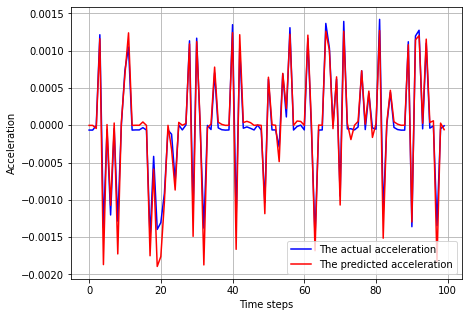

In [7]:
# Check the prediction result with training dataset
model = tf.keras.models.load_model("Models/FFNN.h5")
Valid_Predict = model.predict(x_valid)

plt.figure(figsize=(7,5))
plt.plot(Valid_Predict[3900:4000,0]*0.001, "b",label="The actual acceleration")
plt.plot(y_valid[3900:4000]*0.001, "r", label="The predicted acceleration")
#plt.plot(error[3900:4000], "y", label="error")
plt.legend()
plt.grid(True)
plt.xlabel("Time steps")
plt.ylabel("Acceleration")

Valid_error=np.abs(Valid_Predict[:,0]*0.001-y_valid*0.001)

Valid_MAE1=np.mean(Valid_error)  # the mean absolute error
Valid_MAE2=np.mean(np.abs(y_valid)) # the average angular acceleration value
print(Valid_MAE1)
print(Valid_MAE2)
a=MAE1/MAE2
a

# 5 Simulating angle sequence with the initial condition only.

0.06952422239942113


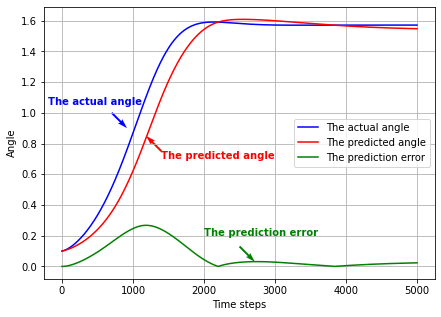

In [8]:
a_test=50
random_length=5000

x1=np.zeros((random_length)).squeeze() # "real" angle
x2=np.zeros((random_length)).squeeze() # "real" angular
x1_test=np.zeros((1, random_length)).squeeze()  # predicted angle
x2_test=np.zeros((1,random_length)).squeeze()  # predicted angular velocity

#Initialize the angle and angular velocity
x1[0]=0.1
x1[1]=0.1001
x2[0]=(x1[1]-x1[0])/di 

x1_test[0]=x1[0]
x2_test[0]=x2[0]

#representive torque parameters
c1=4.2816e-7
c2=1.568
c3=5.7534

#get the "real" angle sequence
for t in range(random_length-1):
    hinput=a_test*1000/(4*np.pi)
    x1[t+1]=x1[t]+di*x2[t]
    x2[t+1]=x2[t]+di*(-c3*x2[t]+c2*np.cos(x1[t])+c1*hinput*abs(hinput)*np.sin(2*x1[t]))
      
model1 = tf.keras.models.load_model("Models/FFNN.h5")
dx1=np.zeros((1, random_length)).squeeze()  #The angular acceleration

#get the predicted angle sequence
for t in range(random_length-1):
    dx1[t]=model1.predict([[x1_test[t],x2_test[t],a_test]])
    x1_test[t+1]=x1_test[t]+x2_test[t]*di
    x2_test[t+1]=x2_test[t]+dx1[t]*di

error=np.abs(x1-x1_test) #Predition error
MAE_angle=np.mean(error) # The mean absolute error
print(MAE_angle)

 #plot figure
plt.figure(figsize=(7,5))
plt.plot(x1,"b",label="The actual angle ")
plt.plot(x1_test,"r", label="The predicted angle" )
plt.plot(error[:5000],"g",label="The prediction error")
plt.legend()
plt.text(-200,1.05,"The actual angle",weight="bold",color="blue")
plt.quiver(700, 1, 1, -1, color='b', width=0.005)
plt.text(1400,0.7,"The predicted angle",weight="bold",color="r")
plt.quiver(1400, 0.75, -1, 1, color='r', width=0.005)
plt.text(2000,0.2,"The prediction error",weight="bold",color="g")
plt.quiver(2500, 0.13, 1, -1, color='g', width=0.005)
plt.grid(True)
plt.xlabel("Time steps")
plt.ylabel("Angle")

plt.savefig("Figures/angle.png")